<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Assignment_7_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7: House Price Prediction Using Boston Housing Data

# Task 1: Import all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Task 2: Data Collection and Loading

In [ ]:
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame.copy()

# Consistent column names (match common descriptions)
df.columns = [c.upper() for c in df.columns]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Task 3: Quick Check of Data

Identify features and target, data types, and basic stats.

In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nDescribe:")
display(df.describe())

# Target & features
TARGET = "MEDV"
FEATURES = [c for c in df.columns if c != TARGET]

Shape: (506, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB
None

Describe:


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


# Task 4: EDA and Data Preprocessing

In [ ]:
# Missing/null check
print(df.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


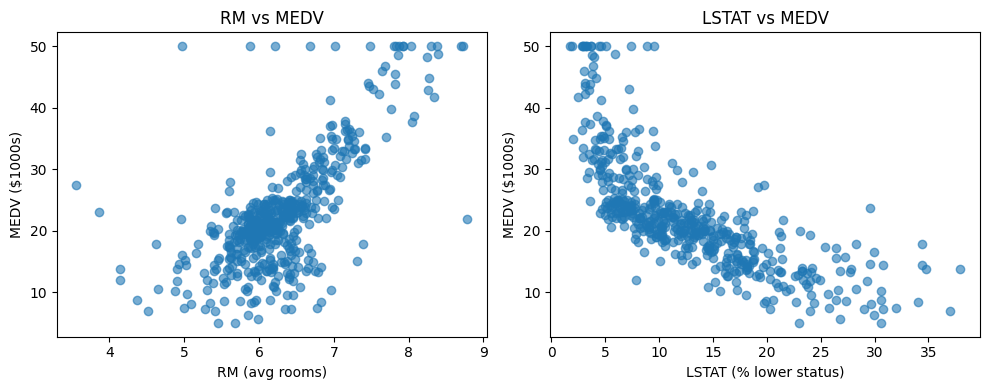

In [ ]:
# Simple scatter plots: a couple of high-signal features vs MEDV
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(df["RM"], df[TARGET], alpha=0.6)
axes[0].set_xlabel("RM (avg rooms)")
axes[0].set_ylabel("MEDV ($1000s)")
axes[0].set_title("RM vs MEDV")

axes[1].scatter(df["LSTAT"], df[TARGET], alpha=0.6)
axes[1].set_xlabel("LSTAT (% lower status)")
axes[1].set_ylabel("MEDV ($1000s)")
axes[1].set_title("LSTAT vs MEDV")

plt.tight_layout()
plt.show()

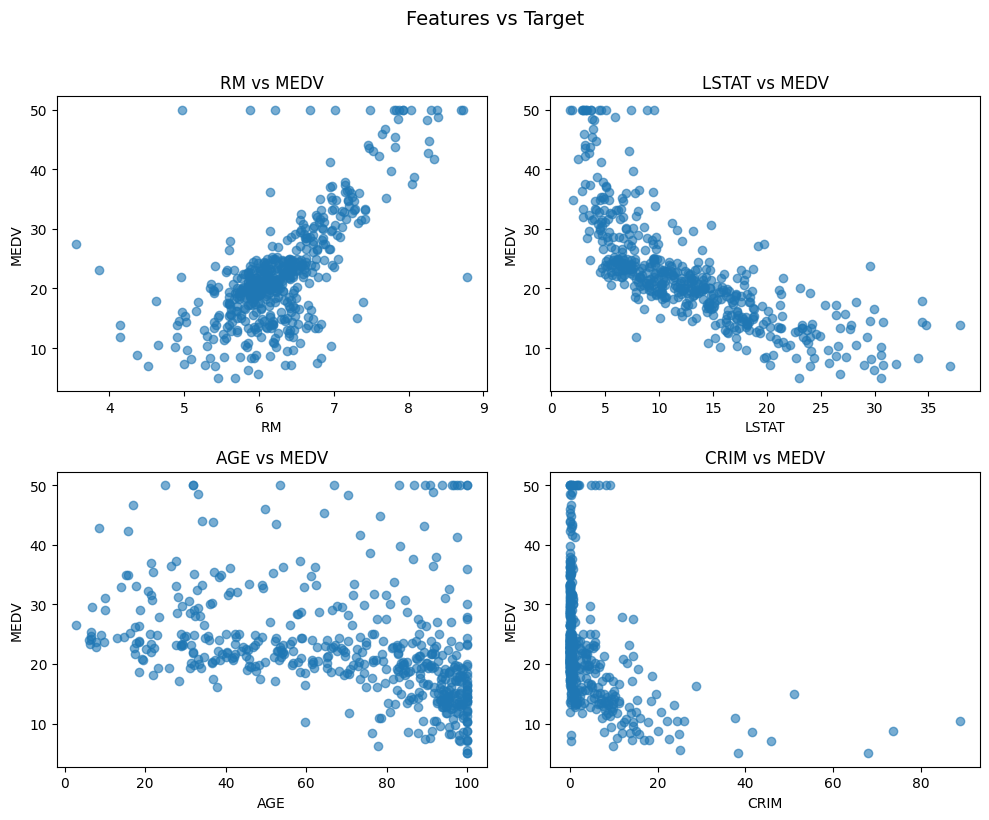

In [ ]:
# Function to automate scatter plots for any feature list vs target
def scatter_features_vs_target(data: pd.DataFrame, features, target: str, ncols=3, figsize=(12, 8)):
    features = list(features)
    n = len(features)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # flatten
    for i, feat in enumerate(features):
        axes[i].scatter(data[feat], data[target], alpha=0.6)
        axes[i].set_xlabel(feat)
        axes[i].set_ylabel(target)
        axes[i].set_title(f"{feat} vs {target}")
    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    fig.suptitle("Features vs Target", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Use the function on a subset
scatter_features_vs_target(df, ["RM", "LSTAT", "AGE", "CRIM"], TARGET, ncols=2, figsize=(10,8))

# Task 5: ML Model Training:

Train/Test Split

In [ ]:
X = df[FEATURES].copy()
y = df[TARGET].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((404, 13), (102, 13))

# Task 6: Model Training
# Option A: Decision Tree (simple baseline)
# Option B: Random Forest (usually better)
# Set use_rf = True to use RandomForest; False for DecisionTree

In [ ]:
use_rf = True

if use_rf:
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
else:
    model = DecisionTreeRegressor(
        max_depth=None,
        random_state=42
    )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

# Task 7: Model Evaluation:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Baseline {model.__class__.__name__} -> RMSE: {rmse:.3f}, R^2: {r2:.3f}")

Baseline RandomForestRegressor -> RMSE: 2.988, R^2: 0.878


# Task 8: Optional Parameter Tuning (Grid Search)

In [ ]:
# 1) Build param grid & base estimator
if use_rf:
    base = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 6, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        # 'auto' is invalid in newer sklearn; use these instead:
        "max_features": ["sqrt", "log2", None],
    }
else:
    base = DecisionTreeRegressor(random_state=42)
    param_grid = {
        "max_depth": [None, 4, 8, 12],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

# 2) Grid search (use MSE scorer and take sqrt later to get RMSE; works on all sklearn versions)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # optimize MSE (will take sqrt for RMSE)
    cv=5,
    n_jobs=-1,
    verbose=0,
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best params:", grid.best_params_)

# 3) Evaluate tuned model
y_pred_gs = best_model.predict(X_test)

mse_gs = mean_squared_error(y_test, y_pred_gs)
rmse_gs = np.sqrt(mse_gs)   # instead of squared=False (keeps compatibility)
r2_gs   = r2_score(y_test, y_pred_gs)

print(f"Tuned {best_model.__class__.__name__} -> RMSE: {rmse_gs:.3f}, R^2: {r2_gs:.3f}")

Best params: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RandomForestRegressor -> RMSE: 3.071, R^2: 0.871


,0
RM,0.279585
LSTAT,0.259877
CRIM,0.072455
NOX,0.072411
INDUS,0.070961
DIS,0.063743
PTRATIO,0.057307
TAX,0.032300
AGE,0.030677
B,0.025758


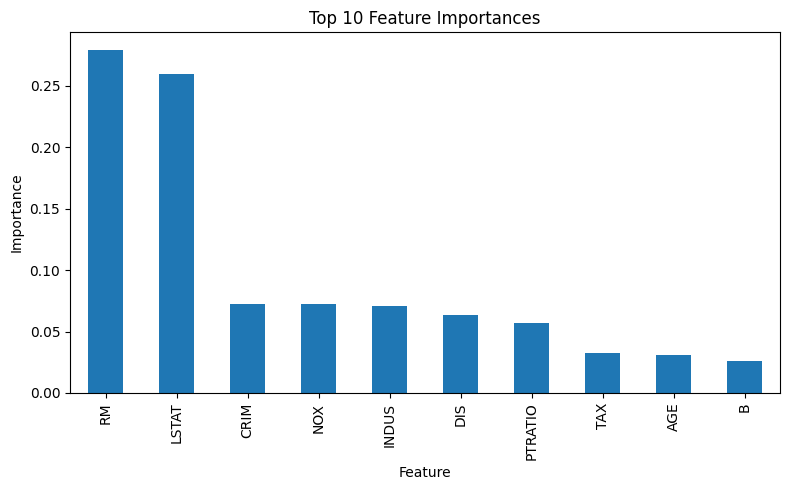

In [ ]:
final_model = best_model if 'best_model' in locals() else model

if hasattr(final_model, "feature_importances_"):
    importances = pd.Series(final_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
    display(importances.head(10))

    plt.figure(figsize=(8,5))
    importances.head(10).plot(kind="bar")
    plt.title("Top 10 Feature Importances")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()

# Task 9: Model Prediction (New Inputs)
Example values provided

In [ ]:
new_data = pd.DataFrame([{
    "CRIM": 0.2, "ZN": 12.5, "INDUS": 7.07, "CHAS": 0, "NOX": 0.5, "RM": 6.5,
    "AGE": 68, "DIS": 4.0, "RAD": 2, "TAX": 250, "PTRATIO": 17, "B": 400, "LSTAT": 12
}])

# Ensure matching feature order/columns
new_data = new_data[[c for c in FEATURES]]
pred_price = final_model.predict(new_data)[0]
print(f"Predicted house price (MEDV, in $1000s): {pred_price:.2f}")
print(f"Approximate $ value: ${pred_price*1000:,.0f}")

Predicted house price (MEDV, in $1000s): 22.59
Approximate $ value: $22,592
